In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import sys
sys.path.append('..')
from utils import load_data, load_all_stocks

SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'UNH']

EVENT_WINDOW_START = -5
EVENT_WINDOW_END = 5
ESTIMATION_WINDOW_START = -120
ESTIMATION_WINDOW_END = -6

def create_earnings_dates_sample():
    """Create sample earnings announcement dates"""
    earnings_events = []
    
    aapl_dates = ['2023-02-02', '2023-05-04', '2023-08-03', '2023-11-02',
                  '2024-02-01', '2024-05-02', '2024-08-01', '2024-11-01', '2025-01-30']
    for date in aapl_dates:
        earnings_events.append({'date': date, 'ticker': 'AAPL'})
    
    msft_dates = ['2023-01-24', '2023-04-25', '2023-07-25', '2023-10-24',
                  '2024-01-30', '2024-04-25', '2024-07-30', '2024-10-30', '2025-01-29']
    for date in msft_dates:
        earnings_events.append({'date': date, 'ticker': 'MSFT'})
    
    googl_dates = ['2023-02-02', '2023-04-25', '2023-07-25', '2023-10-24',
                   '2024-01-30', '2024-04-25', '2024-07-23', '2024-10-29', '2025-01-28']
    for date in googl_dates:
        earnings_events.append({'date': date, 'ticker': 'GOOGL'})
    
    amzn_dates = ['2023-02-02', '2023-04-27', '2023-08-03', '2023-10-26',
                  '2024-02-01', '2024-04-30', '2024-08-01', '2024-10-31', '2025-01-30']
    for date in amzn_dates:
        earnings_events.append({'date': date, 'ticker': 'AMZN'})
    
    meta_dates = ['2023-02-01', '2023-04-26', '2023-07-26', '2023-10-25',
                  '2024-01-31', '2024-04-24', '2024-07-31', '2024-10-30', '2025-01-29']
    for date in meta_dates:
        earnings_events.append({'date': date, 'ticker': 'META'})
    
    df = pd.DataFrame(earnings_events)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

def get_trading_days_around_event(event_date, stock_data, days_before, days_after):
    """Get trading days around an event date"""
    all_dates = stock_data.index
    
    if event_date in all_dates:
        event_idx = all_dates.get_loc(event_date)
    else:
        future_dates = all_dates[all_dates >= event_date]
        if len(future_dates) == 0:
            return None, None
        event_date = future_dates[0]
        event_idx = all_dates.get_loc(event_date)
    
    start_idx = max(0, event_idx - days_before)
    end_idx = min(len(all_dates) - 1, event_idx + days_after)
    
    window_dates = all_dates[start_idx:end_idx + 1]
    
    return window_dates, event_idx - start_idx

In [20]:
def estimate_market_model(stock_returns, market_returns, estimation_window_dates):
    """Estimate market model: R_stock = α + β*R_market + ε"""
    stock_ret = stock_returns.loc[estimation_window_dates].dropna()
    market_ret = market_returns.loc[estimation_window_dates].dropna()
    
    common_dates = stock_ret.index.intersection(market_ret.index)
    stock_ret = stock_ret.loc[common_dates]
    market_ret = market_ret.loc[common_dates]
    
    if len(stock_ret) < 20:
        return None, None
    
    X = market_ret.values.reshape(-1, 1)
    y = stock_ret.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    return model.intercept_, model.coef_[0]

def calculate_abnormal_returns(stock_returns, market_returns, event_date, 
                               stock_data, alpha, beta):
    """Calculate abnormal returns for event window"""
    window_dates, event_pos = get_trading_days_around_event(
        event_date, stock_data, 
        abs(EVENT_WINDOW_START), EVENT_WINDOW_END
    )
    
    if window_dates is None or len(window_dates) < 5:
        return None
    
    results = []
    car = 0
    
    for i, date in enumerate(window_dates):
        if date not in stock_returns.index or date not in market_returns.index:
            continue
        
        actual_return = stock_returns.loc[date]
        market_return = market_returns.loc[date]
        
        expected_return = alpha + beta * market_return
        ar = actual_return - expected_return
        car += ar
        
        relative_day = i - event_pos
        
        results.append({
            'date': date,
            'relative_day': relative_day,
            'actual_return': actual_return,
            'expected_return': expected_return,
            'AR': ar,
            'CAR': car
        })
    
    return pd.DataFrame(results)

In [21]:
def run_event_study(stock_data_dict, earnings_df):
    """Run event study for all earnings announcements"""
    all_returns = {}
    for ticker, data in stock_data_dict.items():
        all_returns[ticker] = data['Close'].pct_change()
    
    market_returns = pd.DataFrame(all_returns).mean(axis=1)
    
    all_events = []
    
    for idx, row in earnings_df.iterrows():
        event_date = row['date']
        ticker = row['ticker']
        
        if ticker not in stock_data_dict:
            continue
        
        stock_data = stock_data_dict[ticker]
        stock_returns = stock_data['Close'].pct_change()
        
        est_window_dates, _ = get_trading_days_around_event(
            event_date, stock_data,
            abs(ESTIMATION_WINDOW_START), abs(ESTIMATION_WINDOW_END)
        )
        
        if est_window_dates is None:
            continue
        
        alpha, beta = estimate_market_model(stock_returns, market_returns, est_window_dates)
        
        if alpha is None:
            continue
        
        ar_df = calculate_abnormal_returns(stock_returns, market_returns, 
                                           event_date, stock_data, alpha, beta)
        
        if ar_df is None:
            continue
        
        ar_df['ticker'] = ticker
        ar_df['event_date'] = event_date
        ar_df['alpha'] = alpha
        ar_df['beta'] = beta
        
        all_events.append(ar_df)
        
        # Condensed output - one line per event
        print(f"{ticker} {event_date.date()}: α={alpha:.6f}, β={beta:.4f}, CAR={ar_df['CAR'].iloc[-1]:+.4f} ({ar_df['CAR'].iloc[-1]*100:+.2f}%)")
    
    if len(all_events) == 0:
        return None
    
    results_df = pd.concat(all_events, ignore_index=True)
    
    return results_df

In [22]:
def calculate_aar_caar(results_df):
    """Calculate AAR and CAAR"""
    aar_df = results_df.groupby('relative_day').agg({
        'AR': ['mean', 'std', 'count']
    }).reset_index()
    
    aar_df.columns = ['relative_day', 'AAR', 'std_AR', 'n_events']
    
    aar_df = aar_df.sort_values('relative_day')
    aar_df['CAAR'] = aar_df['AAR'].cumsum()
    
    aar_df['se'] = aar_df['std_AR'] / np.sqrt(aar_df['n_events'])
    aar_df['t_stat'] = aar_df['AAR'] / aar_df['se']
    aar_df['significant'] = aar_df['t_stat'].abs() > 1.96
    
    return aar_df

def separate_by_car_sign(results_df):
    """Separate events by CAR sign"""
    event_cars = results_df.groupby(['ticker', 'event_date']).agg({
        'AR': 'sum'
    }).reset_index()
    event_cars.columns = ['ticker', 'event_date', 'total_CAR']
    
    positive_events = event_cars[event_cars['total_CAR'] > 0]
    negative_events = event_cars[event_cars['total_CAR'] < 0]
    
    print(f"\nPositive earnings (CAR > 0): {len(positive_events)} events, avg CAR = {positive_events['total_CAR'].mean()*100:+.2f}%")
    print(f"Negative earnings (CAR < 0): {len(negative_events)} events, avg CAR = {negative_events['total_CAR'].mean()*100:+.2f}%")
    
    positive_keys = set(zip(positive_events['ticker'], positive_events['event_date']))
    negative_keys = set(zip(negative_events['ticker'], negative_events['event_date']))
    
    results_positive = results_df[
        results_df.apply(lambda row: (row['ticker'], row['event_date']) in positive_keys, axis=1)
    ]
    results_negative = results_df[
        results_df.apply(lambda row: (row['ticker'], row['event_date']) in negative_keys, axis=1)
    ]
    
    return results_positive, results_negative

In [23]:
def plot_caar(aar_df, title_suffix=""):
    """Plot CAAR with confidence bands"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(aar_df['relative_day'], aar_df['CAAR'], 
             marker='o', linewidth=2, markersize=6, color='blue', label='CAAR')
    
    cumulative_se = np.sqrt((aar_df['se']**2).cumsum())
    ax1.fill_between(aar_df['relative_day'], 
                     aar_df['CAAR'] - 1.96 * cumulative_se,
                     aar_df['CAAR'] + 1.96 * cumulative_se,
                     alpha=0.2, color='blue', label='95% Confidence Band')
    
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Earnings Date')
    
    ax1.set_xlabel('Days Relative to Earnings Announcement', fontsize=11)
    ax1.set_ylabel('Cumulative Average Abnormal Return (CAAR)', fontsize=11)
    ax1.set_title(f'Event Study: Earnings Announcements - CAAR{title_suffix}', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)
    
    colors = ['red' if sig else 'gray' for sig in aar_df['significant']]
    ax2.bar(aar_df['relative_day'], aar_df['AAR'], color=colors, alpha=0.7,
            edgecolor='black', linewidth=0.5)
    
    ax2.errorbar(aar_df['relative_day'], aar_df['AAR'], 
                yerr=1.96 * aar_df['se'], fmt='none', ecolor='black', 
                capsize=3, alpha=0.5)
    
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel('Days Relative to Earnings Announcement', fontsize=11)
    ax2.set_ylabel('Average Abnormal Return (AAR)', fontsize=11)
    ax2.set_title('Daily AAR (Red = Statistically Significant at 95%)', fontsize=14)
    ax2.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_caar_comparison(aar_all, aar_positive, aar_negative):
    """Plot CAAR comparison"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(aar_positive['relative_day'], aar_positive['CAAR'], 
            marker='o', linewidth=2.5, markersize=8, color='green', 
            label=f'Positive Earnings (n={len(aar_positive)})')
    
    ax.plot(aar_negative['relative_day'], aar_negative['CAAR'], 
            marker='o', linewidth=2.5, markersize=8, color='red', 
            label=f'Negative Earnings (n={len(aar_negative)})')
    
    ax.plot(aar_all['relative_day'], aar_all['CAAR'], 
            marker='s', linewidth=2, markersize=6, color='gray', 
            linestyle='--', alpha=0.6, 
            label=f'All Events - Mixed (n={len(aar_all)})')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, 
               label='Earnings Date')
    
    ax.axvspan(-0.5, 0.5, alpha=0.1, color='yellow')
    
    ax.set_xlabel('Days Relative to Earnings Announcement', fontsize=12)
    ax.set_ylabel('Cumulative Average Abnormal Return (CAAR)', fontsize=12)
    ax.set_title('Event Study: CAAR by Earnings Direction\n(Separated by Total CAR Sign)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_aar_table(aar_df, title=""):
    """Create formatted AAR table"""
    print(f"{'Day':<6} {'AAR (%)':<10} {'T-Stat':<10} {'Sig':<5}")
    print('-'*70)
    
    for _, row in aar_df.iterrows():
        day = int(row['relative_day'])
        aar = row['AAR'] * 100
        t_stat = row['t_stat']
        
        if abs(t_stat) > 2.576:
            sig = '***'
        elif abs(t_stat) > 1.96:
            sig = '**'
        elif abs(t_stat) > 1.645:
            sig = '*'
        else:
            sig = ''
        
        print(f"{day:>+3d}    {aar:>7.3f}    {t_stat:>7.3f}    {sig:<5}")
    
    print('-'*70)
    print(f"CAAR[-5,+5]: {aar_df['CAAR'].iloc[-1]*100:.3f}%")
    print("*** p<0.01, ** p<0.05, * p<0.10\n")

MSFT 2023-01-24: α=-0.000265, β=0.9767, CAR=-0.0453 (-4.53%)
META 2023-02-01: α=0.001287, β=1.4753, CAR=+0.1050 (+10.50%)
AMZN 2023-02-02: α=-0.002218, β=1.1912, CAR=-0.0748 (-7.48%)
GOOGL 2023-02-02: α=-0.001205, β=1.0765, CAR=-0.0864 (-8.64%)
AAPL 2023-02-02: α=-0.000337, β=0.9639, CAR=-0.0284 (-2.84%)
MSFT 2023-04-25: α=0.000676, β=0.9474, CAR=+0.0490 (+4.90%)
GOOGL 2023-04-25: α=-0.000818, β=1.0769, CAR=+0.0008 (+0.08%)
META 2023-04-26: α=0.005325, β=1.4199, CAR=+0.0405 (+4.05%)
AMZN 2023-04-27: α=-0.001430, β=1.2102, CAR=+0.0225 (+2.25%)
AAPL 2023-05-04: α=-0.000216, β=0.9125, CAR=+0.0049 (+0.49%)
MSFT 2023-07-25: α=-0.000256, β=0.9731, CAR=-0.0245 (-2.45%)
GOOGL 2023-07-25: α=-0.000773, β=1.1098, CAR=+0.0622 (+6.22%)
META 2023-07-26: α=0.001618, β=1.6938, CAR=+0.0400 (+4.00%)
AAPL 2023-08-03: α=-0.000164, β=0.7124, CAR=-0.0728 (-7.28%)
AMZN 2023-08-03: α=0.000486, β=1.0688, CAR=+0.0962 (+9.62%)
MSFT 2023-10-24: α=-0.000255, β=0.9080, CAR=+0.0766 (+7.66%)
GOOGL 2023-10-24: α=0.000

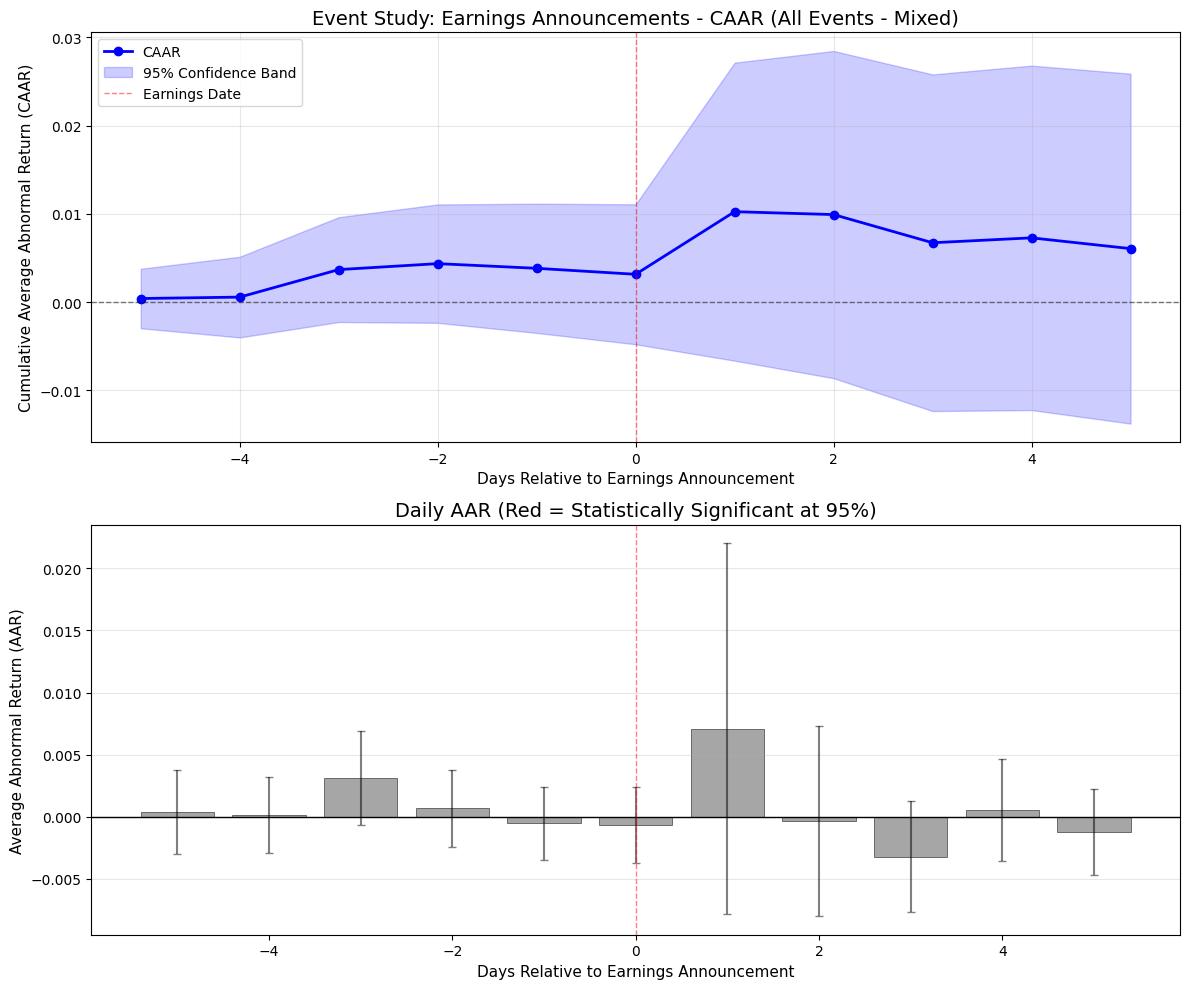


Positive earnings (CAR > 0): 24 events, avg CAR = +5.37%
Negative earnings (CAR < 0): 21 events, avg CAR = -4.83%

POSITIVE EARNINGS (CAR > 0)
Day    AAR (%)    T-Stat     Sig  
----------------------------------------------------------------------
 -5      0.007      0.034         
 -4      0.276      1.321         
 -3      0.543      1.918    *    
 -2      0.155      0.600         
 -1     -0.129     -0.553         
 +0      0.056      0.293         
 +1      3.699      4.146    ***  
 +2      0.468      0.687         
 +3      0.215      0.812         
 +4     -0.027     -0.128         
 +5      0.103      0.577         
----------------------------------------------------------------------
CAAR[-5,+5]: 5.366%
*** p<0.01, ** p<0.05, * p<0.10


NEGATIVE EARNINGS (CAR < 0)
Day    AAR (%)    T-Stat     Sig  
----------------------------------------------------------------------
 -5      0.080      0.270         
 -4     -0.282     -1.247         
 -3      0.047      0.184         
 

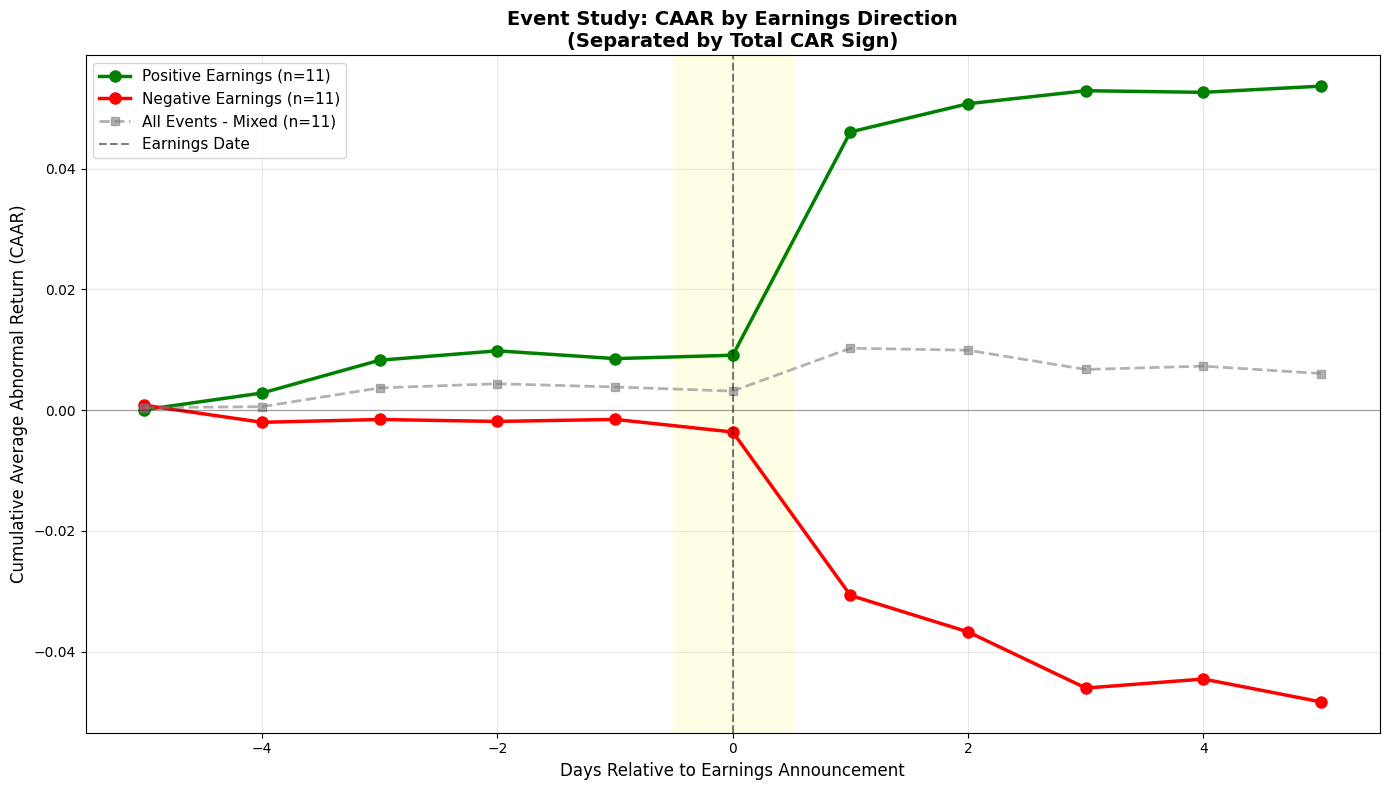


SUMMARY

Positive earnings (n=24): CAAR = +5.37%, Day 0 AAR = +0.06%, 1 significant days
Negative earnings (n=21): CAAR = -4.83%, Day 0 AAR = -0.21%, 3 significant days
All events mixed (n=45): CAAR = +0.61%, 0 significant days

→ Separation reveals significant abnormal returns obscured in mixed sample
→ Most movement occurs Day +1 (after-hours announcements)
→ Negative earnings show stronger persistence (more significant days)



In [24]:
def run_week4_analysis():
    stock_data = load_all_stocks(SYMBOLS)
    
    earnings_df = create_earnings_dates_sample()
    
    results_df = run_event_study(stock_data, earnings_df)
    
    if results_df is None:
        return None
    
    # All events (mixed)
    print("\nALL EVENTS (MIXED)")
    aar_all = calculate_aar_caar(results_df)
    create_aar_table(aar_all, " - ALL EVENTS")
    plot_caar(aar_all, " (All Events - Mixed)")
    
    # Separate by CAR sign
    results_positive, results_negative = separate_by_car_sign(results_df)
    
    aar_positive = calculate_aar_caar(results_positive)
    aar_negative = calculate_aar_caar(results_negative)
    
    print("\nPOSITIVE EARNINGS (CAR > 0)")
    create_aar_table(aar_positive, " - POSITIVE")
    
    print("\nNEGATIVE EARNINGS (CAR < 0)")
    create_aar_table(aar_negative, " - NEGATIVE")
    
    # Comparison plot
    plot_caar_comparison(aar_all, aar_positive, aar_negative)
    
    # Summary
    print("\nSUMMARY")
    print(f"""
Positive earnings (n={len(results_positive.groupby(['ticker','event_date']))}): CAAR = {aar_positive['CAAR'].iloc[-1]*100:+.2f}%, Day 0 AAR = {aar_positive[aar_positive['relative_day']==0]['AAR'].iloc[0]*100:+.2f}%, {sum(aar_positive['significant'])} significant days
Negative earnings (n={len(results_negative.groupby(['ticker','event_date']))}): CAAR = {aar_negative['CAAR'].iloc[-1]*100:+.2f}%, Day 0 AAR = {aar_negative[aar_negative['relative_day']==0]['AAR'].iloc[0]*100:+.2f}%, {sum(aar_negative['significant'])} significant days
All events mixed (n={len(results_df.groupby(['ticker','event_date']))}): CAAR = {aar_all['CAAR'].iloc[-1]*100:+.2f}%, {sum(aar_all['significant'])} significant days

→ Separation reveals significant abnormal returns obscured in mixed sample
→ Most movement occurs Day +1 (after-hours announcements)
→ Negative earnings show stronger persistence (more significant days)
""")
    
    return {
        'earnings_df': earnings_df,
        'results_all': results_df,
        'results_positive': results_positive,
        'results_negative': results_negative,
        'aar_all': aar_all,
        'aar_positive': aar_positive,
        'aar_negative': aar_negative
    }

if __name__ == "__main__":
    results = run_week4_analysis()